In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import loadMNISTLabels, loadMNISTImages, preprocess
from copy import deepcopy

# from mlp_functions import backprop, test, predict

# %% Load images and labels
path = '../MNIST_data'
def get_path(path, file):
    return os.path.join(path, file)

ytest = loadMNISTLabels(get_path(path, 't10k-labels.idx1-ubyte'))
ytrain = loadMNISTLabels(get_path(path, 'train-labels.idx1-ubyte'))

Xtest_raw = loadMNISTImages(get_path(path, 't10k-images.idx3-ubyte'))
Xtrain_raw = loadMNISTImages(get_path(path, 'train-images.idx3-ubyte'))

print(np.shape(Xtrain_raw))

(60000, 28, 28)


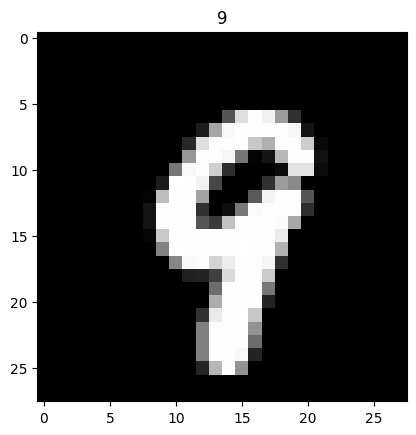

In [4]:
# %% display a random image with label:
img_index = np.random.randint(np.size(Xtrain_raw, axis=0))
img = Xtrain_raw[img_index, :, :]
plt.imshow(img, cmap='gray')
plt.title(str(ytrain[img_index]))
plt.show()

In [73]:
# %% preprocess the images (reshape to vectors and subtract mean)
Xtrain = preprocess(Xtrain_raw)
Xtest = preprocess(Xtest_raw)


In [56]:
# %% Initialize weights
# The weights are initialized to normally distributed random values. Note
# that we scale them by the previous layer size so that the input to
# neurons in different layers will be of similar magnitude.

def get_new_weights(layers_sizes):
    n_weights = len(layers_sizes)-1
    weights = np.zeros((n_weights,), dtype=np.ndarray)
    for i in range(n_weights):
        weights[i] = np.divide(np.random.standard_normal((layers_sizes[i+1],layers_sizes[i])), layers_sizes[i])
    return weights

In [113]:
def get_activation_function():
    return np.tanh


def get_activation_function_derivative():
    return lambda x: 1 - np.tanh(x)**2


def predict(weights, X):
    """
    The function takes as input an array of the weights and a matrix (X)
    with images. The outputs should be a vector of the predicted
    labels for each image, and a matrix whose columns are the activation of
    the last layer for each image.
    last_layer_activation should be of size [10 X num_samples]
    predicted_labels should be of size [1 X num_samples]
    The predicted label should correspond to the index with maximal
    activation in the last layer
    :param weights: array of the network weights
    :param X: samples matrix (match the dimensions to your input)
    :return:
    """
    activation_function = get_activation_function()
    s_layer = X.T
    for i in range(0, len(weights)):
        _, s_layer = forword_pass_one_layer(weights[i], s_layer, activation_function)
    predicted_labels = np.argmax(s_layer, axis=0)
    return predicted_labels, s_layer


def digit_to_one_hot(y):
    one_hot = np.zeros((10, len(y)))
    one_hot[y, np.arange(len(y))] = 1
    return one_hot


def one_hot_to_digit(one_hot):
    return np.argmax(one_hot, axis=0)


def get_loss(y_hat, y):
    return 0.5 * np.mean((np.sum((y_hat - digit_to_one_hot(y))**2, axis=0)))


def test(weights, Xtest, ytest):
    """
    This function receives the Network weights, a matrix of samples and
    the corresponding labels, and outputs the classification
    accuracy and mean loss.
    The accuracy is equal to the ratio of correctly labeled images.
    The loss is given the square distance of the last layer activation
    and the 0-1 representation of the true label
    Note that ytest in the MNIST data is given as a vector of labels from 0-9. To calculate the loss you
    need to convert it to 0-1 (one-hot) representation with 1 at the position
    corresponding to the label and 0 everywhere else (label "2" maps to
    (0,0,1,0,0,0,0,0,0,0) etc.)
    :param weights: array of the network weights
    :param Xtest: samples matrix (match the dimensions to your input)
    :param ytest: corresponding labels
    :return:
    """
    predicted_labels, y_hat = predict(weights, Xtest)
    loss = get_loss(y_hat, ytest)
    accuracy = np.mean(predicted_labels == ytest)
    return accuracy, loss


def backprop(weights, X, y):
    """
    This function receives a set of weights, a matrix with images
    and the corresponding labels. The output should be an array
    with the gradients of the loss with respect to the weights, averaged over
    the samples. It should also output the average loss of the samples.
    :param weights: an array of length L where the n-th cell contains the
    connectivity matrix between layer n-1 and layer n.
    :param X: samples matrix (match the dimensions to your input)
    :param y: corresponding labels
    :return:
    """
    activation_function = get_activation_function()
    activation_function_derivative = get_activation_function_derivative()
    h_layers, s_layers = forward_pass(weights, X, activation_function)
    mean_loss = get_loss(s_layers[-1], y)
    grads = backword_pass(weights, h_layers, s_layers, y, activation_function_derivative)
    return grads, mean_loss


def backword_pass(weights, h_layers, s_layers, y, activation_function_derivative):
    delta_layers = get_delta_layers(weights, h_layers, s_layers, y, activation_function_derivative)
    number_of_samples = len(y)
    weights_gradients_tensor = get_weights_gradients_tensor(weights, delta_layers, s_layers, number_of_samples)
    return weights_gradients_tensor


def get_weights_gradients_tensor(weights, delta_layers, s_layers, number_of_samples):
    gradients_tensor_per_sample = get_weights_gradients_tensor_per_sample(weights, delta_layers, s_layers, number_of_samples)
    gradients_tensor = np.zeros((len(weights),), dtype=np.ndarray)
    for l in range(len(weights)):
        gradients_tensor[l] = np.mean(gradients_tensor_per_sample[l], axis=0)
    return gradients_tensor


# tensor[l][miu][i][j] = the derivative of the loss with respect to the weight connecting the i-th neuron in the l+1-th layer
# and the j-th neuron in the l-th layer for the miu-th sample in the batch (0 <= l <= L-1)
#
# s[l][j][miu] = the output of the j-th neuron in the l-th layer for the miu-th sample in the batch (0 <= l <= L)
# delta[l][i][miu] = the derivative of the loss with respect to the input for the activation function (h) 
# of the i-th neuron in the l+1-th layer and the miu-th sample in the batch (0 <= l <= L-1)
def get_weights_gradients_tensor_per_sample(weights, delta_layers, s_layers, number_of_samples):
    tensor = np.zeros((len(weights),), dtype=np.ndarray)
    for l in range(len(weights)):
        tensor[l] = np.zeros((number_of_samples, weights[l].shape[0], weights[l].shape[1]))
        for miu in range(number_of_samples):
            tensor[l][miu] = np.outer(delta_layers[l][:, miu], s_layers[l][:, miu])
    return tensor


# delta[l][i][miu] = the derivative of the loss with respect to the input for the activation function (h) 
# of the i-th neuron in the l+1-th layer and the miu-th sample in the batch (0 <= l <= L-1)
# s[l] = the output of the l_th layer 
# h[l] = the input for the activation function of the l_th layer
# weights[l] = the weights connecting the l+1_th layer to the l-th layer
def get_delta_layers(weights, h_layers, s_layers, y, activation_function_derivative):
    delta_layers = np.zeros((len(weights),), dtype=np.ndarray)
    for l in range(len(weights)-1, -1, -1):
        if l == len(weights)-1:
            delta_layers[l] = (s_layers[l+1] - digit_to_one_hot(y)) * activation_function_derivative(h_layers[l+1])
        else:
            delta_layers[l] = np.dot(weights[l+1].T, delta_layers[l+1]) * activation_function_derivative(h_layers[l+1])
    return delta_layers


def forword_pass_one_layer(weights, s_layer, activation_function):
    next_h_layer =  np.dot(weights, s_layer)
    next_s_layer = activation_function(next_h_layer)
    return next_h_layer, next_s_layer


def forward_pass(weights, X, activation_function):
    number_of_layers = len(weights)+1
    h_layers = np.zeros((number_of_layers,), dtype=np.ndarray)
    s_layers = np.zeros((number_of_layers,), dtype=np.ndarray)
        
    s_layer =  deepcopy(X.T)
    s_layers[0] = s_layer
    for i in range(1, number_of_layers):
        h_layer, s_layer = forword_pass_one_layer(weights[i-1], s_layer, activation_function)
        h_layers[i] = h_layer
        s_layers[i] = s_layer
        
    return h_layers, s_layers


# backprop(weights, Xtrain[50:120,:], ytrain[50:120])
# print(test(weights, Xtest, ytest))

In [142]:
def train_network_a(layers_sizes, epochs, etas, batch_size):  
    num_of_etas = len(etas)
    # %% Training
    N = np.size(Xtrain, axis=0)                        # number of samples
    n_mbs = np.ceil(N/batch_size).astype(np.int16)    # number of minibatches
    
    # create vectors for each eta to keep track of the loss and accuracy
    batch_loss_arr = np.empty((num_of_etas, epochs * n_mbs, )) * np.nan
    test_loss_arr = np.empty((num_of_etas, epochs * n_mbs, )) * np.nan
    test_acc_arr = np.empty((num_of_etas, epochs * n_mbs, )) * np.nan
    initial_weights = get_new_weights(layers_sizes)
    weights_arr = np.array([deepcopy(initial_weights) for _ in range(num_of_etas)])
    
    iteration = 0
    for i in range(epochs):
        perm = np.random.permutation(N)
        for j in range(n_mbs):
            idxs = perm[(batch_size * j):min((batch_size * (j+1))-1, N-1)]
    
            # pick a batch of samples:
            X_mb = Xtrain[idxs, :]
            y_mb = ytrain[idxs]
    
            for eta_index, eta in enumerate(etas):
                # compute the gradients:
                grads, loss = backprop(weights_arr[eta_index], X_mb, y_mb)
        
                # keep track of the batch loss
                batch_loss_arr[eta_index][iteration] = loss
        
                # uncomment the next line to keep track of test loss and error.
                if iteration % 10 == 0:
                    test_acc_arr[eta_index][iteration], test_loss_arr[eta_index][iteration]= test(weights_arr[eta_index], Xtest, ytest)
                # Note: evaluating the test_loss for each batch will slow down
                # computation. If it is too slow you can instead evaluate the test
                # loss at a lower frequency (once every 10 batches or so...)
        
                # update the weights:
                for k in range(len(weights_arr[eta_index])):
                    weights_arr[eta_index][k] = weights_arr[eta_index][k] - eta * grads[k]
        
            iteration = iteration + 1  # counts the number of updates
        
        for eta_index, eta in enumerate(etas):
            acc, loss = test(weights_arr[eta_index], Xtest, ytest)
            print('Done epoch %d, test accuracy for eta %f : %f' % (i, eta, acc))
        
    return weights_arr, batch_loss_arr, test_loss_arr, test_acc_arr


In [189]:
# Q1 - Train a network with one hidden layer of 64 neurons and learning rate of η = 0.1 for at least 4
# epochs using a batch size of 32.

layers_sizes_a = [784, 64, 10] # flexible, but must be [784,...,10]
epochs_a = 6      # number of times to repeat over the whole training set
etas = [0.01, 0.1, 1]       # learning rate
batch_size_a = 32 # number of samples in each training batch

weights_a, batch_loss_a, test_loss_a, test_acc_a = train_network_a(layers_sizes_a, epochs_a, etas, batch_size_a)

/var/folders/_7/xf1wjsfx5bs9p2klwbsmtf640000gq/T/ipykernel_48424/676609540.py:8: RuntimeWarning: invalid value encountered in multiply
  batch_loss_arr = np.empty((num_of_etas, epochs * n_mbs, )) * np.nan
/var/folders/_7/xf1wjsfx5bs9p2klwbsmtf640000gq/T/ipykernel_48424/676609540.py:9: RuntimeWarning: invalid value encountered in multiply
  test_loss_arr = np.empty((num_of_etas, epochs * n_mbs, )) * np.nan


KeyboardInterrupt: 

In [190]:
# np.save('../backups/weights_a.npy', weights_a)
# np.save('../backups/batch_loss_a.npy', batch_loss_a)
# np.save('../backups/test_loss_a.npy', test_loss_a)
# np.save('../backups/test_acc_a.npy', test_acc_a)


In [148]:
def get_not_nan_vectors(v):
    return v[~np.isnan(v)], np.arange(len(v))[~np.isnan(v)]

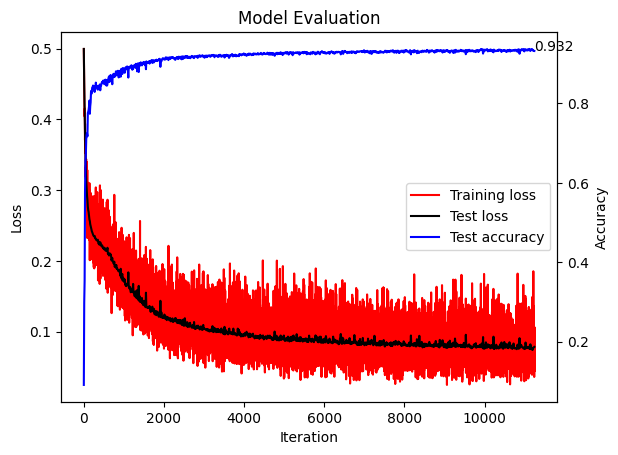

In [157]:
# Q1.1.5 - Plot the batch loss over time and see if it decreases.
weights, batch_loss, test_loss, test_acc = weights_a[1], batch_loss_a[1], test_loss_a[1], test_acc_a[1]

fig, ax1 = plt.subplots()
ax1.plot(batch_loss, 'r-', label='Training loss')
test_loss_v, test_loss_idx = get_not_nan_vectors(test_loss)
ax1.plot(test_loss_idx, test_loss_v, 'k-', label='Test loss')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
test_acc_v, test_acc_idx = get_not_nan_vectors(test_acc)
ax2.plot(test_acc_idx, test_acc_v, label='Test accuracy', color='blue')
ax2.set_ylabel('Accuracy')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

# Add test accuracy at the last iteration
last_iteration = test_acc_idx[-1]
last_accuracy = test_acc_v[-1]
ax2.annotate(f'{last_accuracy:.3f}', xy=(last_iteration, last_accuracy), xytext=(last_iteration, last_accuracy),fontsize=10)


plt.title('Model Evaluation')
plt.show()


In [176]:
# Q1.2.1

# %% Display 10 misclassifications with highest loss
# Example showing some misclassifications
predicted_labels, output = predict(weights, Xtest)
t = np.zeros((10,len(ytest)))
for i in range(len(ytest)):
    t[ytest[i], i] = 1

test_losses = sum((output-t)**2)
sorted_index = np.argsort(-test_losses) # - for descending

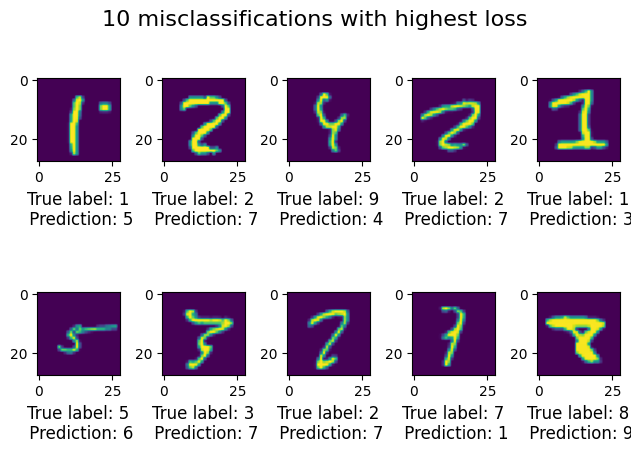

In [186]:
idxs = sorted_index[:10]
plt.figure()
for k in range(10):
    ax = plt.subplot(2, 5, k+1)
    x = Xtest_raw[idxs[k], :, :]
    ax.imshow(x)
    ax.set_xlabel('True label: %d\n Prediction: %d' % (ytest[idxs[k]], predicted_labels[idxs[k]]), fontsize=12)

plt.tight_layout()
plt.suptitle('10 misclassifications with highest loss', fontsize=16)
plt.show()

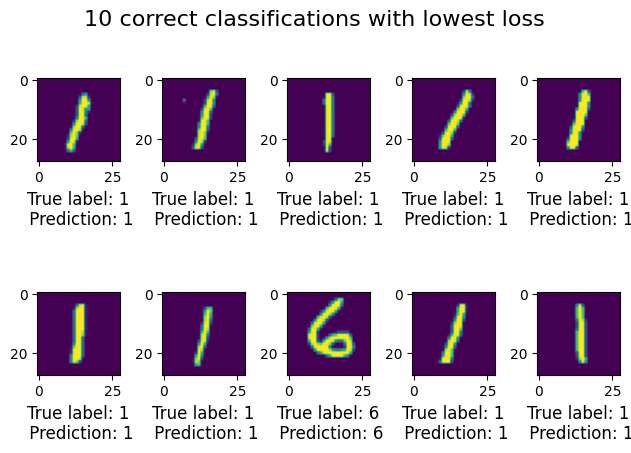

In [187]:
idxs = sorted_index[-10:]
plt.figure()
for k in range(10):
    ax = plt.subplot(2, 5, k+1)
    x = Xtest_raw[idxs[k], :, :]
    ax.imshow(x)
    ax.set_xlabel('True label: %d\n Prediction: %d' % (ytest[idxs[k]], predicted_labels[idxs[k]]), fontsize=12)

plt.tight_layout()
plt.suptitle('10 correct classifications with lowest loss', fontsize=16)
plt.show()

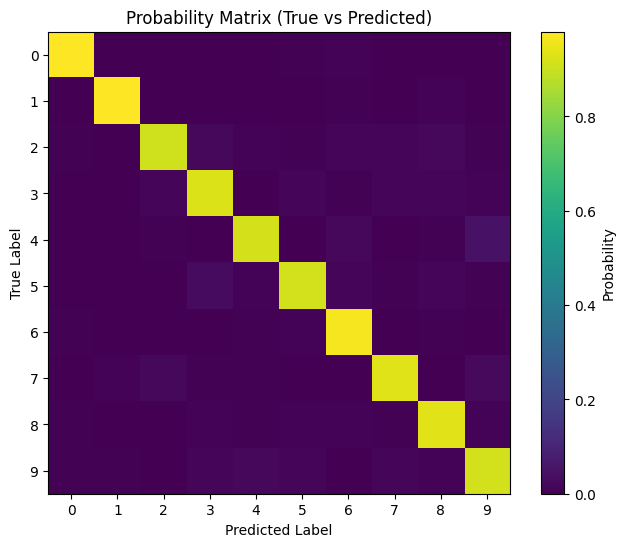

In [180]:
# Initialize probability matrix
M = np.zeros((10, 10))

# Calculate probabilities
for true_label, predicted_label in zip(ytest, predicted_labels):
    M[true_label][predicted_label] += 1

# Normalize each row to get probabilities
row_sums = M.sum(axis=1)
M_normalized = M / row_sums[:, np.newaxis]

# Plot the probability matrix
plt.figure(figsize=(8, 6))
plt.imshow(M_normalized, cmap='viridis')
plt.colorbar(label='Probability')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Probability Matrix (True vs Predicted)')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.grid(False)
plt.show()

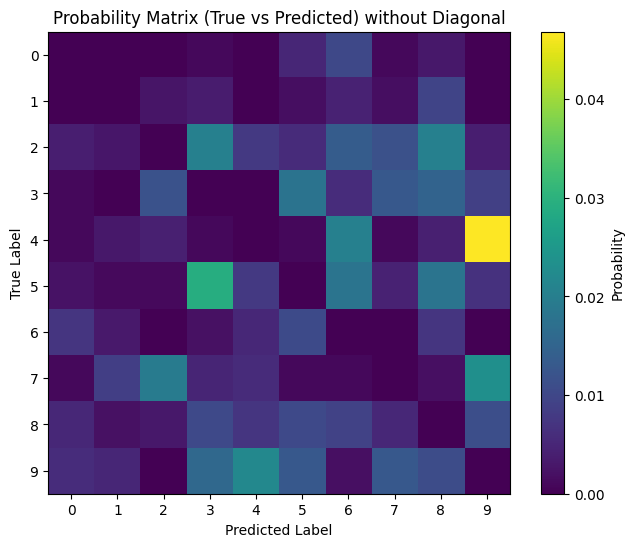

In [181]:
M_normalized_diag = deepcopy(M_normalized)
np.fill_diagonal(M_normalized_diag, 0)
row_sums = M_normalized_diag.sum(axis=1)
M_normalized = M_normalized_diag / row_sums[:, np.newaxis]

plt.figure(figsize=(8, 6))
plt.imshow(M_normalized_diag, cmap='viridis')
plt.colorbar(label='Probability')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Probability Matrix (True vs Predicted) without Diagonal')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.grid(False)
plt.show()

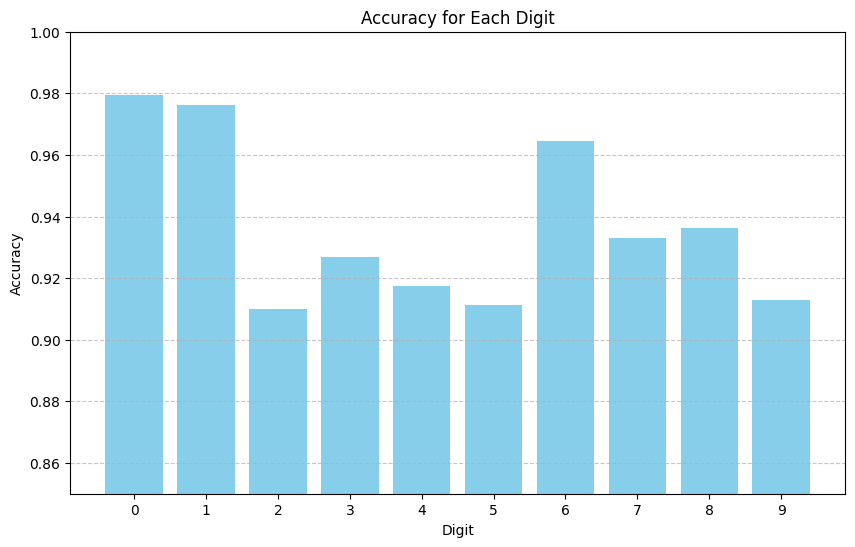

In [185]:
# Initialize dictionary to store counts of correct and total instances for each digit
digit_counts = {digit: {'correct': 0, 'total': 0} for digit in range(10)}

# Count correct and total instances for each digit
for true_label, predicted_label in zip(ytest, predicted_labels):
    if true_label == predicted_label:
        digit_counts[true_label]['correct'] += 1
    digit_counts[true_label]['total'] += 1

# Calculate accuracy for each digit
accuracies = [digit_counts[digit]['correct'] / digit_counts[digit]['total'] for digit in range(10)]

# Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(10), accuracies, color='skyblue')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Digit')
plt.xticks(range(10))
plt.ylim(0.85, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

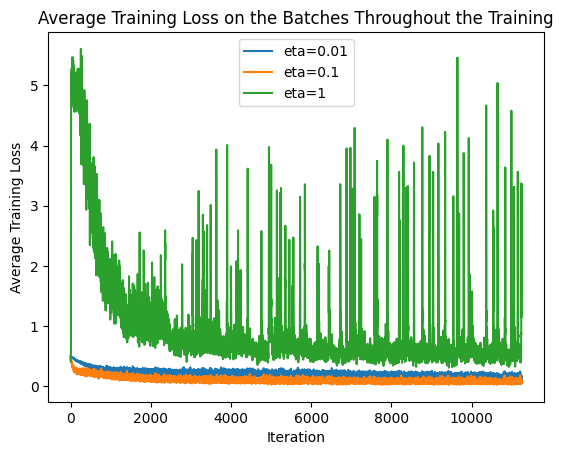

In [193]:
# q1.2.2 - For each eta Plot the average training loss on the batches throughout the training. 

# Plot the average training loss on the batches throughout the training.
fig, ax = plt.subplots()
for i in range(len(etas)):
    ax.plot(batch_loss_a[i],  label=f'eta={etas[i]}')
ax.set_xlabel('Iteration')
ax.set_ylabel('Average Training Loss')
ax.legend()
plt.title('Average Training Loss on the Batches Throughout the Training')
plt.show()
